# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

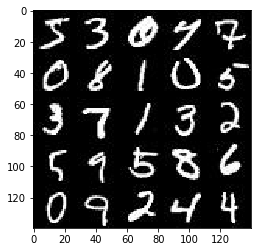

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

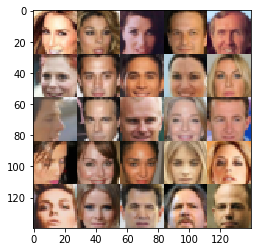

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (28, 28, 3)
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')  
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    x = images
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        print(relu3.get_shape())

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\mrsmm\Anaconda3\envs\3.6.8\lib\site-packages\IPython\core\interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-5-1ec3448a7e9b>", line 23, in <module>
    tests.test_model_inputs(model_inputs)  File "D:\Udacity_Projects\Deep_Learning\deep-learning\face_generation\problem_unittests.py", line 14, in func_wrapper
    return result  File "D:\Udacity_Projects\Deep_Learning\deep-learning\face_generation\problem_unittests.py", line 68, in test_model_inputs
    _ch

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, units=4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum( 0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, filters=32, kernel_size=5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.2 * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, filters=out_channel_dim, kernel_size=3, strides=1,
                                            padding='same')
        out = tf.tanh(logits)
        print(out.get_shape())
        
    return out

    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
(?, 28, 28, 5)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
(?, 4, 4, 256)
(?, 4, 4, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10 
    show_every=100
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
(?, 4, 4, 256)
(?, 4, 4, 256)
Epoch 1/2... Discriminator Loss: 5.3818... Generator Loss: 0.0055
Epoch 1/2... Discriminator Loss: 4.2186... Generator Loss: 0.0163
Epoch 1/2... Discriminator Loss: 2.6273... Generator Loss: 0.1059
Epoch 1/2... Discriminator Loss: 2.0638... Generator Loss: 0.2034
Epoch 1/2... Discriminator Loss: 1.6929... Generator Loss: 0.2760
Epoch 1/2... Discriminator Loss: 1.8983... Generator Loss: 0.2060
Epoch 1/2... Discriminator Loss: 1.9083... Generator Loss: 0.1929
Epoch 1/2... Discriminator Loss: 1.8489... Generator Loss: 0.2033
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.3464
(?, 28, 28, 1)


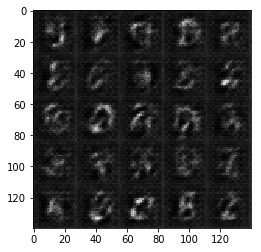

Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.3218
Epoch 1/2... Discriminator Loss: 1.7382... Generator Loss: 0.2230
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 0.1553... Generator Loss: 2.5526
Epoch 1/2... Discriminator Loss: 0.1090... Generator Loss: 2.5789
Epoch 1/2... Discriminator Loss: 0.0374... Generator Loss: 5.6626
Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 2.4188
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 3.4981
Epoch 1/2... Discriminator Loss: 0.7559... Generator Loss: 3.4866
Epoch 1/2... Discriminator Loss: 3.0759... Generator Loss: 0.0538
(?, 28, 28, 1)


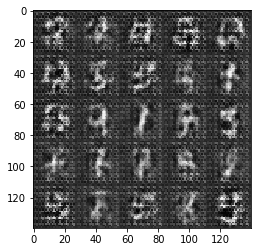

Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 1.1097
Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 7.3239
Epoch 1/2... Discriminator Loss: 2.7649... Generator Loss: 0.0768
Epoch 1/2... Discriminator Loss: 0.2614... Generator Loss: 3.5673
Epoch 1/2... Discriminator Loss: 0.0658... Generator Loss: 5.3914
Epoch 1/2... Discriminator Loss: 0.3110... Generator Loss: 1.6354
Epoch 1/2... Discriminator Loss: 2.8253... Generator Loss: 8.7524
Epoch 1/2... Discriminator Loss: 2.0833... Generator Loss: 0.1587
Epoch 1/2... Discriminator Loss: 0.3774... Generator Loss: 2.1586
(?, 28, 28, 1)


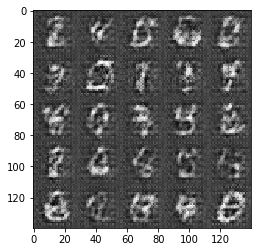

Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 2.0112
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.3282
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 1.3153
Epoch 1/2... Discriminator Loss: 0.1706... Generator Loss: 3.2173
Epoch 1/2... Discriminator Loss: 0.2979... Generator Loss: 1.7614
Epoch 1/2... Discriminator Loss: 0.1023... Generator Loss: 2.9064
Epoch 1/2... Discriminator Loss: 3.0022... Generator Loss: 4.0976
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.7858
(?, 28, 28, 1)


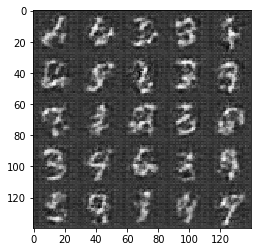

Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 1.6133
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 4.2801
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 3.5314
Epoch 1/2... Discriminator Loss: 2.6399... Generator Loss: 0.1126
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 0.7000
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.4001
(?, 28, 28, 1)


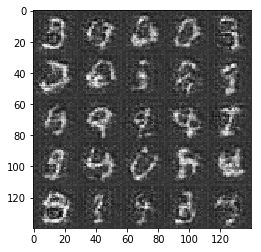

Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 2.1294
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 0.0809... Generator Loss: 4.7648
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 0.0526... Generator Loss: 4.6249
Epoch 1/2... Discriminator Loss: 0.1002... Generator Loss: 4.2242
Epoch 1/2... Discriminator Loss: 0.2007... Generator Loss: 2.1573
Epoch 1/2... Discriminator Loss: 0.0167... Generator Loss: 6.1395
Epoch 1/2... Discriminator Loss: 5.3964... Generator Loss: 6.2351
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 1.9376
(?, 28, 28, 1)


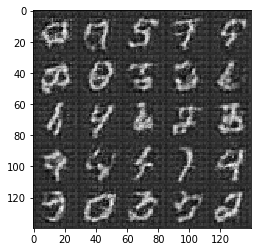

Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 1.4995
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 1.1820
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 1.8237
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 2.3995
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.7629
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 2.0548
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.9727
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.5918
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 2.5308
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 2.2397
(?, 28, 28, 1)


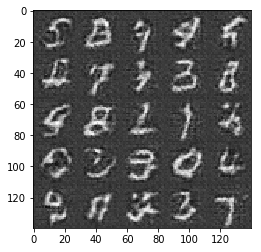

Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 3.1437
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 2.2490
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 3.6194
Epoch 1/2... Discriminator Loss: 0.2902... Generator Loss: 1.7273
Epoch 1/2... Discriminator Loss: 5.7319... Generator Loss: 6.5522
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.3480
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.7214... Generator Loss: 0.2549
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 0.2201... Generator Loss: 2.9976
(?, 28, 28, 1)


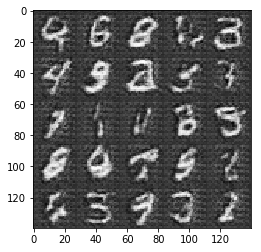

Epoch 1/2... Discriminator Loss: 0.0845... Generator Loss: 4.2105
Epoch 1/2... Discriminator Loss: 0.4668... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.0853... Generator Loss: 3.5801
Epoch 1/2... Discriminator Loss: 0.4263... Generator Loss: 2.7451
Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 0.9381
Epoch 1/2... Discriminator Loss: 1.6986... Generator Loss: 0.2691
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 0.0847... Generator Loss: 4.4693
Epoch 1/2... Discriminator Loss: 0.1336... Generator Loss: 2.6246
Epoch 1/2... Discriminator Loss: 0.0897... Generator Loss: 3.0532
(?, 28, 28, 1)


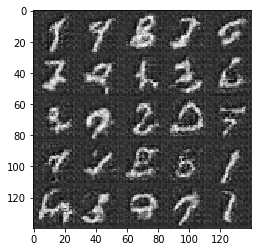

Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 0.0711... Generator Loss: 3.7263
Epoch 2/2... Discriminator Loss: 0.1944... Generator Loss: 2.2375
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 4.5974
Epoch 2/2... Discriminator Loss: 1.7777... Generator Loss: 0.2766
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.7813
Epoch 2/2... Discriminator Loss: 0.4612... Generator Loss: 2.9496
Epoch 2/2... Discriminator Loss: 0.1047... Generator Loss: 3.1718
(?, 28, 28, 1)


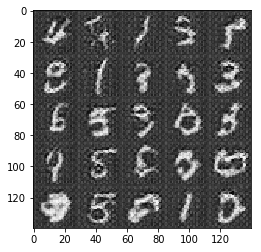

Epoch 2/2... Discriminator Loss: 0.2223... Generator Loss: 1.9503
Epoch 2/2... Discriminator Loss: 0.1978... Generator Loss: 3.4720
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 0.1554... Generator Loss: 4.2128
Epoch 2/2... Discriminator Loss: 1.8731... Generator Loss: 0.2354
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.5354
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 0.1753... Generator Loss: 3.3331
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.3200
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 4.3333
(?, 28, 28, 1)


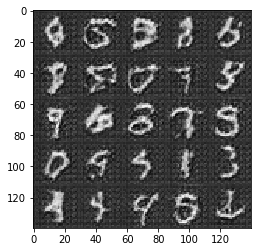

Epoch 2/2... Discriminator Loss: 0.1252... Generator Loss: 3.2625
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 0.0331... Generator Loss: 4.4600
Epoch 2/2... Discriminator Loss: 0.0239... Generator Loss: 4.9009
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 7.2384
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.4293
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 2.5314
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 2.4251
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.0736
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 0.8787
(?, 28, 28, 1)


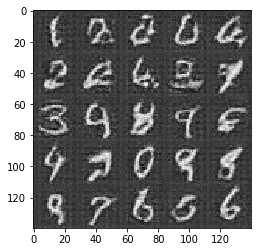

Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 1.4479
Epoch 2/2... Discriminator Loss: 0.0368... Generator Loss: 4.0299
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 0.1432... Generator Loss: 2.3928
Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 2.6890
(?, 28, 28, 1)


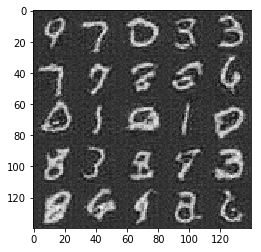

Epoch 2/2... Discriminator Loss: 0.4768... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 2.7180... Generator Loss: 0.1046
Epoch 2/2... Discriminator Loss: 0.5009... Generator Loss: 2.3789
Epoch 2/2... Discriminator Loss: 0.1421... Generator Loss: 3.0220
Epoch 2/2... Discriminator Loss: 0.1635... Generator Loss: 2.8461
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 4.4720
Epoch 2/2... Discriminator Loss: 0.1664... Generator Loss: 2.3344
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 0.0785... Generator Loss: 4.3817
Epoch 2/2... Discriminator Loss: 0.4394... Generator Loss: 1.2294
(?, 28, 28, 1)


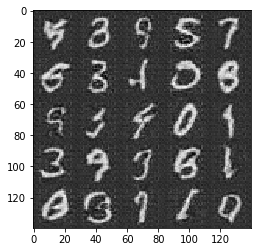

Epoch 2/2... Discriminator Loss: 1.6345... Generator Loss: 7.9627
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 0.5490
Epoch 2/2... Discriminator Loss: 0.1598... Generator Loss: 2.4920
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.5116
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 0.5652... Generator Loss: 1.6075
(?, 28, 28, 1)


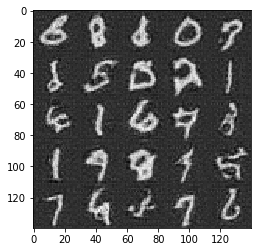

Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 1.8371
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 1.3817
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 0.0599... Generator Loss: 3.9615
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 2.1413
Epoch 2/2... Discriminator Loss: 0.4458... Generator Loss: 2.7350
Epoch 2/2... Discriminator Loss: 0.1297... Generator Loss: 3.3025
Epoch 2/2... Discriminator Loss: 0.1229... Generator Loss: 2.7215
Epoch 2/2... Discriminator Loss: 0.0666... Generator Loss: 4.0209
Epoch 2/2... Discriminator Loss: 0.0687... Generator Loss: 3.4911
(?, 28, 28, 1)


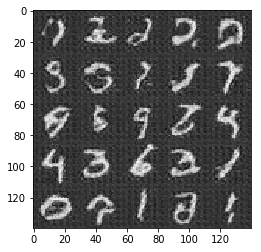

Epoch 2/2... Discriminator Loss: 0.1217... Generator Loss: 2.5572
Epoch 2/2... Discriminator Loss: 0.2777... Generator Loss: 5.8043
Epoch 2/2... Discriminator Loss: 0.2942... Generator Loss: 1.7235
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.5746
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 3.0228
Epoch 2/2... Discriminator Loss: 0.1022... Generator Loss: 2.8342
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 2.4996
Epoch 2/2... Discriminator Loss: 0.1782... Generator Loss: 2.3225
Epoch 2/2... Discriminator Loss: 0.0926... Generator Loss: 4.7742
(?, 28, 28, 1)


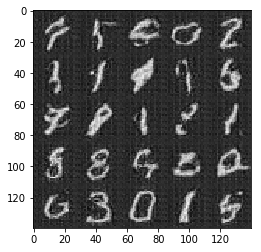

Epoch 2/2... Discriminator Loss: 0.1294... Generator Loss: 2.8203
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.1551
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 2.6356
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 2.3568
Epoch 2/2... Discriminator Loss: 0.2769... Generator Loss: 1.9346
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 0.4535... Generator Loss: 1.4833
Epoch 2/2... Discriminator Loss: 3.2813... Generator Loss: 0.0760
Epoch 2/2... Discriminator Loss: 0.6233... Generator Loss: 1.0432
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.7862
(?, 28, 28, 1)


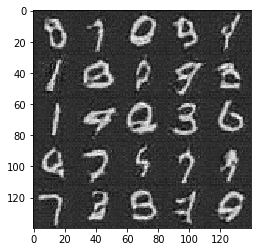

Epoch 2/2... Discriminator Loss: 0.2036... Generator Loss: 2.3840
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 0.9215
Epoch 2/2... Discriminator Loss: 0.2464... Generator Loss: 2.6016
Epoch 2/2... Discriminator Loss: 0.0636... Generator Loss: 4.0795
Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 1.4883
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 5.3994
Epoch 2/2... Discriminator Loss: 0.0435... Generator Loss: 4.8061


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
(?, 4, 4, 256)
(?, 4, 4, 256)
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 4.4038... Generator Loss: 0.0172
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.3495
Epoch 1/1... Discriminator Loss: 0.1494... Generator Loss: 3.5923
Epoch 1/1... Discriminator Loss: 0.2014... Generator Loss: 3.1138
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 3.4285... Generator Loss: 8.7154
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 2.6572
Epoch 1/1... Discriminator Loss: 0.2071... Generator Loss: 2.0998
Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 3.1776
(?, 28, 28, 3)


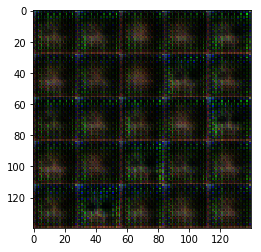

Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 1.6827
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.7611
Epoch 1/1... Discriminator Loss: 0.2836... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.2384... Generator Loss: 1.9825
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.9134
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 2.9721
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 3.0713
Epoch 1/1... Discriminator Loss: 6.9617... Generator Loss: 11.2052
Epoch 1/1... Discriminator Loss: 2.3013... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.9704
(?, 28, 28, 3)


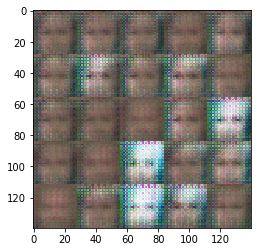

Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 2.2186
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 0.1612... Generator Loss: 2.5250
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 1.8078... Generator Loss: 5.7782
Epoch 1/1... Discriminator Loss: 1.6818... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 2.5872
(?, 28, 28, 3)


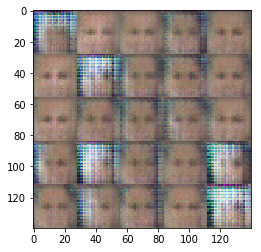

Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 3.8672
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.0900... Generator Loss: 3.0098
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.2750
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 5.2838
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 1.6536... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 2.0858
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 1.8374
(?, 28, 28, 3)


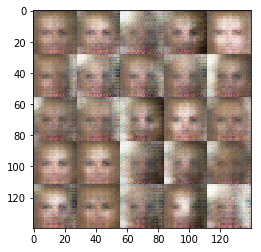

Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 3.7754
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 3.4395
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 1.7968
Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 2.5013
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 3.2496
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 2.8636... Generator Loss: 0.0711
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.5086
(?, 28, 28, 3)


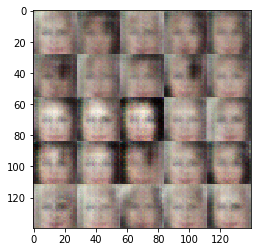

Epoch 1/1... Discriminator Loss: 0.0881... Generator Loss: 3.1012
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 2.8001
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 0.3004... Generator Loss: 5.2354
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 4.0580
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.9067... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 4.9885
Epoch 1/1... Discriminator Loss: 2.1639... Generator Loss: 3.8094
(?, 28, 28, 3)


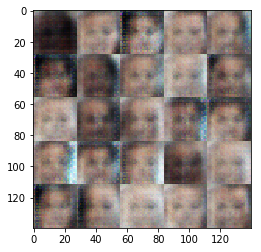

Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 0.2254... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 2.5515... Generator Loss: 0.2728
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 3.4920
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 2.8675
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 2.3511
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 3.0677
Epoch 1/1... Discriminator Loss: 1.8811... Generator Loss: 0.2023
(?, 28, 28, 3)


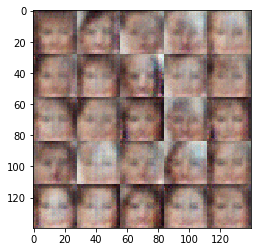

Epoch 1/1... Discriminator Loss: 0.0721... Generator Loss: 3.2441
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 3.8738
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 5.5906
Epoch 1/1... Discriminator Loss: 0.0742... Generator Loss: 3.3332
Epoch 1/1... Discriminator Loss: 0.2264... Generator Loss: 2.0790
Epoch 1/1... Discriminator Loss: 1.9033... Generator Loss: 3.0379
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 3.2439
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 3.7981
Epoch 1/1... Discriminator Loss: 2.3406... Generator Loss: 3.9495
Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 1.8856
(?, 28, 28, 3)


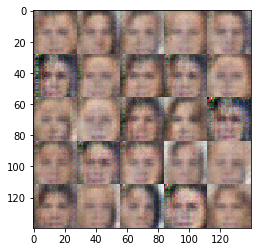

Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.5341
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 2.0416... Generator Loss: 0.1577
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 4.0402
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 2.9823
Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 2.9583
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 3.3215
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 2.2783
Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 2.5807
(?, 28, 28, 3)


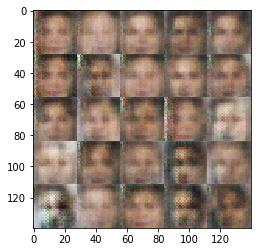

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 3.8344
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 2.3044... Generator Loss: 4.2696
Epoch 1/1... Discriminator Loss: 2.7281... Generator Loss: 0.1169
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 3.0332
(?, 28, 28, 3)


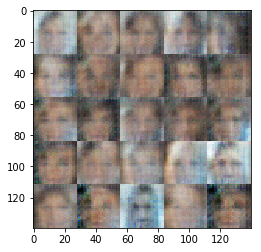

Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 3.5692
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.1925
Epoch 1/1... Discriminator Loss: 0.1658... Generator Loss: 5.9308
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 4.7425
Epoch 1/1... Discriminator Loss: 0.0364... Generator Loss: 4.7515
Epoch 1/1... Discriminator Loss: 2.3636... Generator Loss: 5.1913
Epoch 1/1... Discriminator Loss: 0.2185... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 3.6090
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 5.3863
(?, 28, 28, 3)


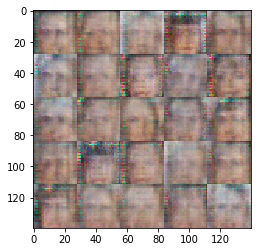

Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 2.8601
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 5.0952
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 2.0024... Generator Loss: 0.1974
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.3586
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.0550
(?, 28, 28, 3)


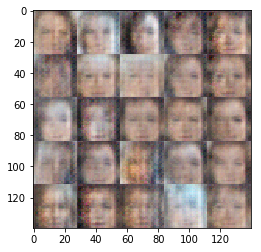

Epoch 1/1... Discriminator Loss: 0.1198... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 0.1395... Generator Loss: 2.1945
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 2.7622... Generator Loss: 0.0781
Epoch 1/1... Discriminator Loss: 1.8786... Generator Loss: 0.2151
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.5454
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 4.1757
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 2.1039
(?, 28, 28, 3)


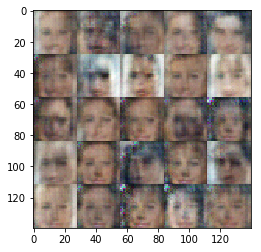

Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 4.8389
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.0221
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 3.4423
Epoch 1/1... Discriminator Loss: 3.2768... Generator Loss: 0.0471
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 1.7772
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 3.5485
Epoch 1/1... Discriminator Loss: 2.2266... Generator Loss: 0.1416
Epoch 1/1... Discriminator Loss: 2.0590... Generator Loss: 0.2538
(?, 28, 28, 3)


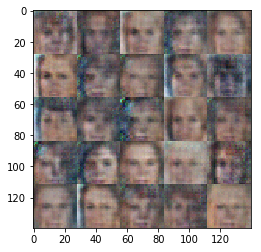

Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 4.2180
Epoch 1/1... Discriminator Loss: 0.1124... Generator Loss: 3.4416
Epoch 1/1... Discriminator Loss: 1.8825... Generator Loss: 4.6081
Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 5.8537
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 6.5088
Epoch 1/1... Discriminator Loss: 1.7372... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 0.0799... Generator Loss: 4.2827
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 6.4828
(?, 28, 28, 3)


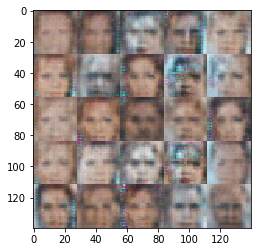

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 2.5834
Epoch 1/1... Discriminator Loss: 0.1335... Generator Loss: 2.8838
Epoch 1/1... Discriminator Loss: 0.1624... Generator Loss: 2.1611
Epoch 1/1... Discriminator Loss: 5.9703... Generator Loss: 5.2131
Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 3.9539
Epoch 1/1... Discriminator Loss: 0.0726... Generator Loss: 3.4240
Epoch 1/1... Discriminator Loss: 0.1201... Generator Loss: 2.5321
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.3768
(?, 28, 28, 3)


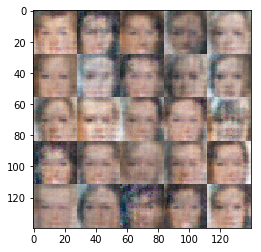

Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.2925
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.2720
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 2.4169... Generator Loss: 0.1140
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 1.6830
(?, 28, 28, 3)


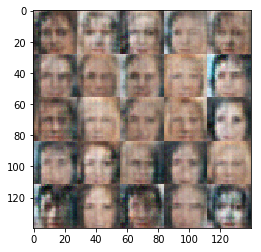

Epoch 1/1... Discriminator Loss: 2.4656... Generator Loss: 0.1321
Epoch 1/1... Discriminator Loss: 0.2070... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.2348... Generator Loss: 5.5076
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 1.9239
Epoch 1/1... Discriminator Loss: 1.9108... Generator Loss: 0.1977
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 4.0927
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 4.4178
Epoch 1/1... Discriminator Loss: 1.9384... Generator Loss: 0.2940
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.2784
(?, 28, 28, 3)


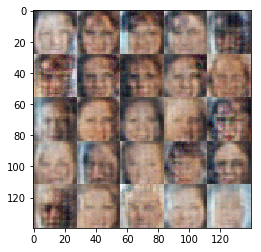

Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 5.0692
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 3.4676
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 2.2282
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 7.0271
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 3.5777
Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 0.2210
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 5.3065
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 0.3000... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 2.9544
(?, 28, 28, 3)


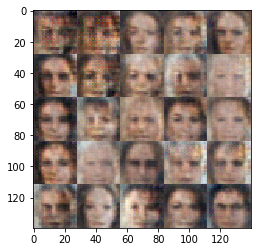

Epoch 1/1... Discriminator Loss: 3.5912... Generator Loss: 5.4889
Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 0.3528
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 1.7494... Generator Loss: 0.2755
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 4.0643
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 3.0546
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 3.5957
(?, 28, 28, 3)


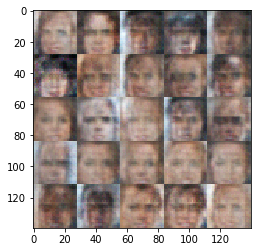

Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 3.0113
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.3245
Epoch 1/1... Discriminator Loss: 1.7852... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.3328
(?, 28, 28, 3)


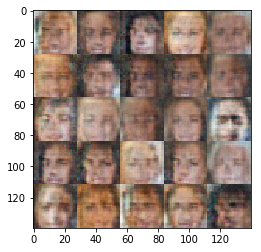

Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 0.1706... Generator Loss: 4.2140
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 2.9732... Generator Loss: 4.5658
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 2.6683
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 2.3533
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 4.2998
Epoch 1/1... Discriminator Loss: 1.9137... Generator Loss: 3.3541
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 0.8523
(?, 28, 28, 3)


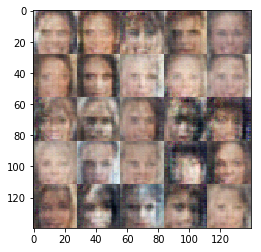

Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 4.1297
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 2.1213... Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6681
(?, 28, 28, 3)


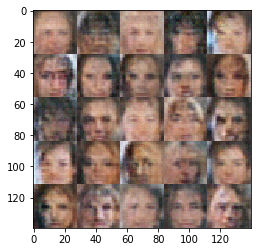

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 0.2455... Generator Loss: 2.1988
Epoch 1/1... Discriminator Loss: 2.6652... Generator Loss: 0.0824
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 2.3608
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.2854
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.3387
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 2.8525
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 3.3940
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 0.8886
(?, 28, 28, 3)


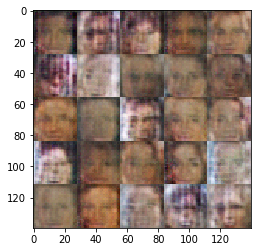

Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.3458
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 3.3045
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.9783... Generator Loss: 3.0283
Epoch 1/1... Discriminator Loss: 3.0372... Generator Loss: 3.6478
(?, 28, 28, 3)


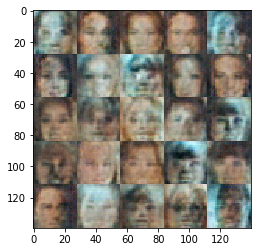

Epoch 1/1... Discriminator Loss: 1.7347... Generator Loss: 0.2670
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 0.1504... Generator Loss: 2.7306
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 2.2152
Epoch 1/1... Discriminator Loss: 1.9273... Generator Loss: 2.5244
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.3034
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 2.3827
Epoch 1/1... Discriminator Loss: 0.2900... Generator Loss: 1.6723
(?, 28, 28, 3)


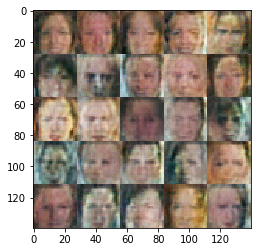

Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 3.3110
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.2354
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.1755... Generator Loss: 2.2505
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 4.6148
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 2.2692
Epoch 1/1... Discriminator Loss: 4.4032... Generator Loss: 4.9341
(?, 28, 28, 3)


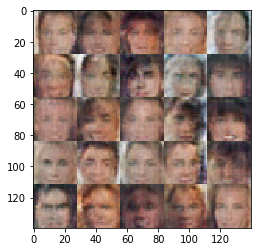

Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 2.5209
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 2.3692
Epoch 1/1... Discriminator Loss: 3.2562... Generator Loss: 3.8908
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 3.2245
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 1.6377
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.8281
(?, 28, 28, 3)


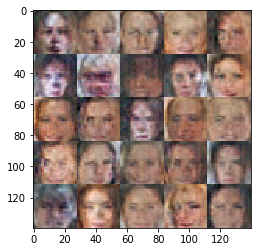

Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 1.4264
Epoch 1/1... Discriminator Loss: 1.7132... Generator Loss: 0.2555
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.3844
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.7658
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.3593
(?, 28, 28, 3)


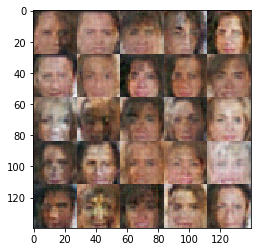

Epoch 1/1... Discriminator Loss: 1.8520... Generator Loss: 0.1992
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 0.2933... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.2748
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.3876
(?, 28, 28, 3)


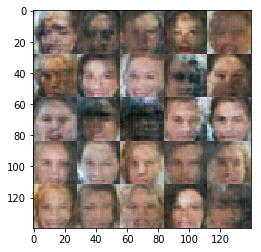

Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.3066
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 3.5244
Epoch 1/1... Discriminator Loss: 1.9211... Generator Loss: 2.0963
(?, 28, 28, 3)


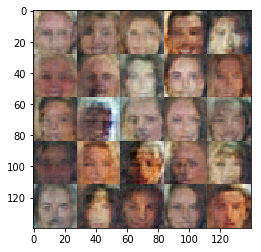

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.3582
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 1.5645
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.2564
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.7507... Generator Loss: 0.2465
(?, 28, 28, 3)


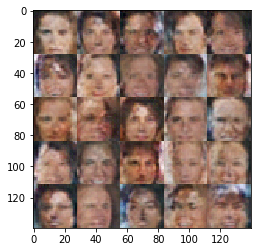

Epoch 1/1... Discriminator Loss: 0.2413... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.3046
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 3.4544
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 1.7341
(?, 28, 28, 3)


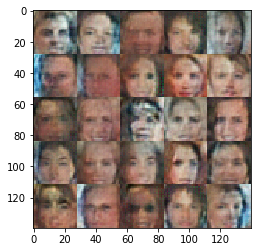

Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.8823... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.2452
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 2.0047
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 2.1164... Generator Loss: 0.1595
(?, 28, 28, 3)


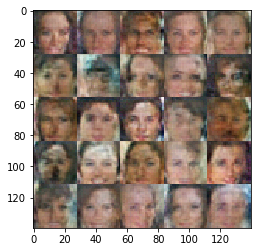

Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 2.1960... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.6651
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.2200
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 1.4830
(?, 28, 28, 3)


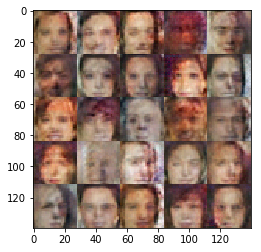

Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 2.9965... Generator Loss: 3.6229
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 0.1553... Generator Loss: 2.2820
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 3.2698
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.4492
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.3208
(?, 28, 28, 3)


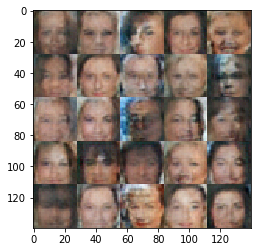

Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.2911
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 2.3690... Generator Loss: 0.1216
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.4104
(?, 28, 28, 3)


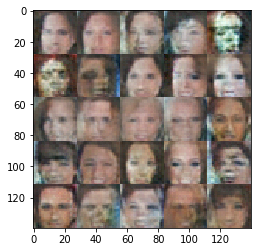

Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.2714
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 2.9109... Generator Loss: 3.6507
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.5069
(?, 28, 28, 3)


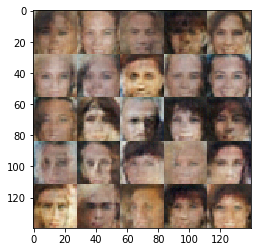

Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 2.7846
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 2.5335
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 1.8902
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.3388
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.9223... Generator Loss: 0.2007
(?, 28, 28, 3)


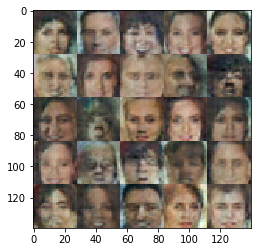

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 3.1679... Generator Loss: 0.0510
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.9263... Generator Loss: 0.1967
Epoch 1/1... Discriminator Loss: 2.0206... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.2602
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 0.7929
(?, 28, 28, 3)


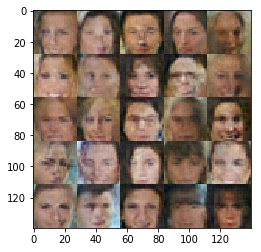

Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 3.0594
Epoch 1/1... Discriminator Loss: 2.0988... Generator Loss: 0.1546
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.2547
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.1266
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.3024
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 3.5241
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.3836
(?, 28, 28, 3)


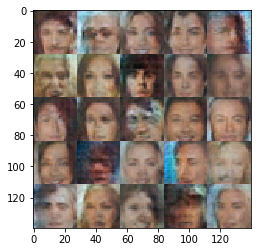

Epoch 1/1... Discriminator Loss: 0.2886... Generator Loss: 2.5416
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.3317
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 3.3581
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 1.9408
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.0369
(?, 28, 28, 3)


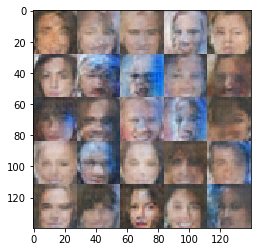

Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.2707
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.7428
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 1.6674... Generator Loss: 0.2508
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.2695
Epoch 1/1... Discriminator Loss: 2.3897... Generator Loss: 0.1187
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.3609
(?, 28, 28, 3)


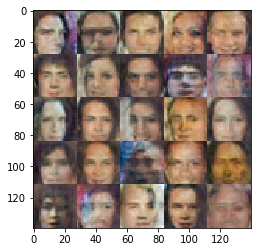

Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 0.3183... Generator Loss: 1.8382
Epoch 1/1... Discriminator Loss: 2.4285... Generator Loss: 0.1143
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.8900... Generator Loss: 0.2172
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 0.2501
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.5014
(?, 28, 28, 3)


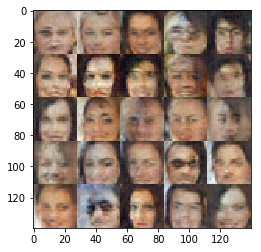

Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 3.4734... Generator Loss: 3.8810
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.6569
(?, 28, 28, 3)


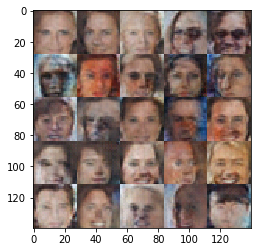

Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.8940... Generator Loss: 0.2005
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.8676... Generator Loss: 0.2269
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.3133
Epoch 1/1... Discriminator Loss: 2.3704... Generator Loss: 0.1174
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.9472... Generator Loss: 0.1765
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 0.8171
(?, 28, 28, 3)


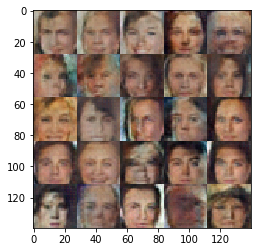

Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.2678
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.3396
Epoch 1/1... Discriminator Loss: 2.1788... Generator Loss: 0.1833
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.5827
(?, 28, 28, 3)


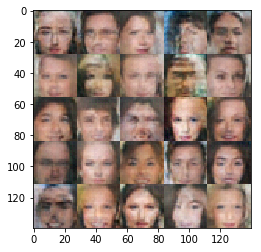

Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 2.3449... Generator Loss: 0.1308
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 0.2024
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.3573
(?, 28, 28, 3)


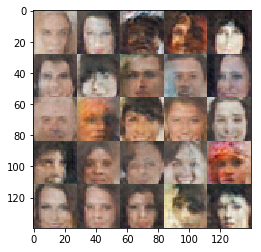

Epoch 1/1... Discriminator Loss: 0.3258... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.3314
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 1.6279
Epoch 1/1... Discriminator Loss: 1.8478... Generator Loss: 0.2360
Epoch 1/1... Discriminator Loss: 1.9587... Generator Loss: 0.2257
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.6037
(?, 28, 28, 3)


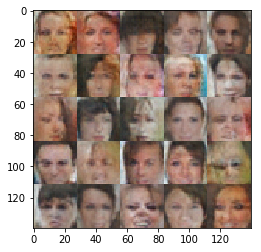

Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.7026... Generator Loss: 0.2526
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.8070... Generator Loss: 0.2197
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 2.5071
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.3313
(?, 28, 28, 3)


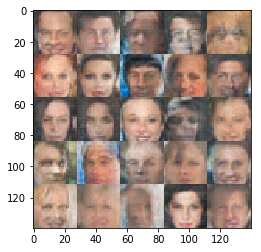

Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 2.0384
Epoch 1/1... Discriminator Loss: 1.8568... Generator Loss: 0.2175
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.9286
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 2.2175... Generator Loss: 0.1415
Epoch 1/1... Discriminator Loss: 2.3779... Generator Loss: 0.1085
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.3625
(?, 28, 28, 3)


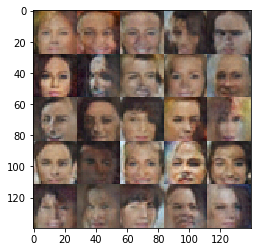

Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.6278
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 2.0319... Generator Loss: 0.1655
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.6644... Generator Loss: 0.2525
(?, 28, 28, 3)


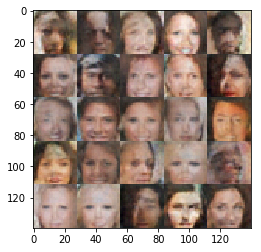

Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 1.8072
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 1.9425... Generator Loss: 0.1938
Epoch 1/1... Discriminator Loss: 1.7899... Generator Loss: 0.2295
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.4501
(?, 28, 28, 3)


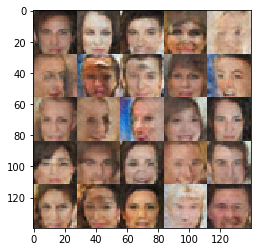

Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.4177
Epoch 1/1... Discriminator Loss: 2.4747... Generator Loss: 0.1367
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 0.2432
Epoch 1/1... Discriminator Loss: 2.2086... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.2670
Epoch 1/1... Discriminator Loss: 2.4915... Generator Loss: 2.7737
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.4315
(?, 28, 28, 3)


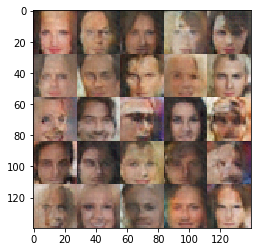

Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 0.1865
Epoch 1/1... Discriminator Loss: 1.9123... Generator Loss: 0.2048
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.9806... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.3381
(?, 28, 28, 3)


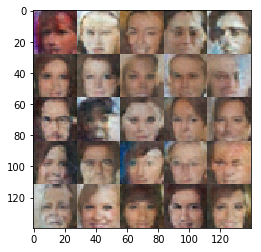

Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 1.9746
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 2.0901... Generator Loss: 0.1614
Epoch 1/1... Discriminator Loss: 1.7469... Generator Loss: 0.2299
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.5142
(?, 28, 28, 3)


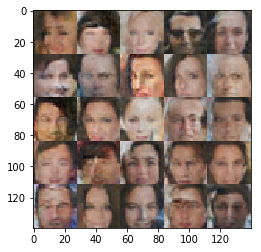

Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.7720... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 2.0636
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.6628
(?, 28, 28, 3)


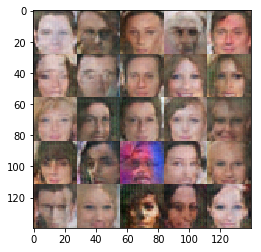

Epoch 1/1... Discriminator Loss: 1.9457... Generator Loss: 0.1921
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.2605
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.7408
(?, 28, 28, 3)


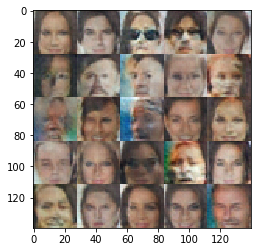

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.8475... Generator Loss: 0.2077
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 1.8066
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.6732
(?, 28, 28, 3)


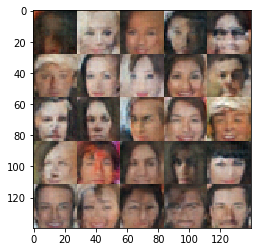

Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 2.1006... Generator Loss: 0.1547
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.8474
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 1.0272
(?, 28, 28, 3)


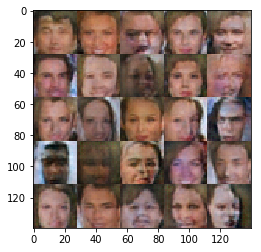

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.7719
Epoch 1/1... Discriminator Loss: 1.9361... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 2.0828
Epoch 1/1... Discriminator Loss: 2.1036... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.2522
Epoch 1/1... Discriminator Loss: 2.0241... Generator Loss: 0.1805
(?, 28, 28, 3)


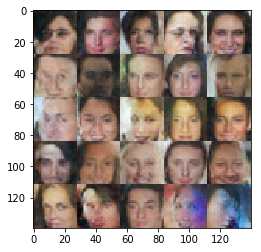

Epoch 1/1... Discriminator Loss: 2.5997... Generator Loss: 0.0954
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.9808... Generator Loss: 0.1865
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 1.7585... Generator Loss: 0.2417
Epoch 1/1... Discriminator Loss: 1.7278... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.8772... Generator Loss: 0.2291
(?, 28, 28, 3)


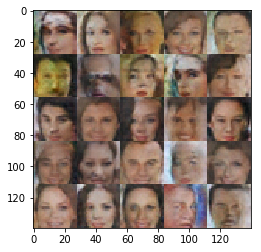

Epoch 1/1... Discriminator Loss: 1.9965... Generator Loss: 0.1878
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 2.1215... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.6729
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.2808
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.2621
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.8147... Generator Loss: 0.2317
Epoch 1/1... Discriminator Loss: 2.5126... Generator Loss: 1.6195
(?, 28, 28, 3)


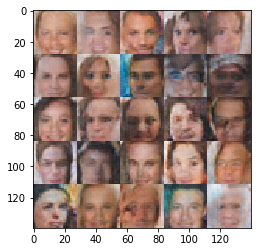

Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.8676


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.